In [1]:
pip install dlib

In [2]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2


--2024-08-29 20:19:38--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.9MB/s    in 4.2s    

2024-08-29 20:19:43 (14.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [3]:
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2



## Dlib's Face Landmark Detection

In [4]:
# importing required library
import cv2
import dlib
import numpy as np
import os

In [5]:
# inintializing face detector and landmark detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [6]:
#getting landmarks
def get_landmarks(image, rect):
  return np.matrix([[p.x,p.y] for p in predictor(image, rect).parts()])

In [7]:
# creating face mask
def get_face_mask(image, landmarks):
  mask = np.zeros_like(image)
  points = cv2.convexHull(landmarks)
  cv2.fillConvexPoly(mask, points, 255)
  return mask

In [8]:
# wraping image
def wrap_image(src, dst, src_points, dst_points, size):
  transformation_matrix = cv2.getAffineTransform(np.float32(src_points), np.float32(dst_points))
  warp_image = cv2.warpAffine(src, transformation_matrix, (size[1], size[0]), None, flags = cv2.INTER_LINEAR, borderMode = cv2.BORDER_REFLECT_101)
  return warp_image

In [9]:
# correcting colors
def correcting_colors(im1, im2, landmarks1):
  blur_amount = 0.6*np.linalg.norm(np.mean(landmarks1[36:42], axis = 0) - np.mean(landmarks1[42:48], axis = 0))
  blur_amount = int(blur_amount)
  if blur_amount % 2 == 0:
    blur_amount += 1
  im2 = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)
  im2 = im2.astype(np.float32)
  im1 = im1.astype(np.float32)
  return (im2 * (im1/im2).mean(axis = (0,1))).astype(np.uint8)

In [10]:
def face_swaps(image1, image2):
    # Detect faces in both images
    rects1 = detector(image1, 1)
    rects2 = detector(image2, 1)

    if len(rects1) == 0 or len(rects2) == 0:
        print("No face detected in one of the images.")
        return None

    # Get landmarks for the first face in both images
    landmarks1 = get_landmarks(image1, rects1[0])
    landmarks2 = get_landmarks(image2, rects2[0])

    # Extract the face region from the first image and create a mask
    face1 = image1[rects1[0].top():rects1[0].bottom(), rects1[0].left():rects1[0].right()]
    mask1 = get_face_mask(image1, landmarks1)

    # Warp the second face to match the first face's shape
    warped_face2 = wrap_image(image2, image1, landmarks2[0:3], landmarks1[0:3], face1.shape)

    # Correct the color of the warped face to match the first face
    warped_face2 = correcting_colors(face1, warped_face2, landmarks1)

    # Mask and replace the original face with the swapped face
    combined_mask = get_face_mask(image1, landmarks1)

    # Resize warped_face2 to match image1
    warped_face2 = cv2.resize(warped_face2, (image1.shape[1], image1.shape[0]))

    # Resize combined_mask to match image1
    combined_mask = cv2.resize(combined_mask, (image1.shape[1], image1.shape[0]))

    # Calculate the center for seamlessClone
    center = (int(np.mean(landmarks1[:, 0])), int(np.mean(landmarks1[:, 1])))
    print("Calculated center for seamlessClone:", center)

    # Check if center and mask are within bounds
    if (0 <= center[0] < image1.shape[1]) and (0 <= center[1] < image1.shape[0]):
        result = cv2.seamlessClone(warped_face2, image1, combined_mask, center, cv2.NORMAL_CLONE)
        return result
    else:
        print("Center point is out of bounds of the target image.")
        return None


In [11]:
pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 92.9 MB/s eta 0:00:00


In [12]:
# loading images
import fitz
def extract_images(pdf_path, output_path):
    # Open the PDF file
    pdf_document = fitz.open(pdf_path)

    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for pg_num in range(len(pdf_document)):  # Correctly using the number of pages
        page = pdf_document.load_page(pg_num)
        images = page.get_images(full=True)  # Fixed variable name

        for img_index, img in enumerate(images):
            xref = img[0]
            base_image = pdf_document.extract_image(xref)
            image_bytes = base_image["image"]
            img_ext = base_image["ext"]

            # Save image (correctly indented)
            image_filename = f"{output_path}/image_page{pg_num + 1}_{img_index + 1}.{img_ext}"
            with open(image_filename, "wb") as img_file:
                img_file.write(image_bytes)

    pdf_document.close()


extract_images("/content/Face_BG_Swap_Sample.pdf","/content/img_folder")

In [13]:
#load images
image1 = cv2.imread("/content/img_folder/image_page1_1.jpeg")
image2 = cv2.imread("/content/img_folder/image_page1_3.jpeg")

In [14]:
#let's perform face wrap
swap_results = face_swaps(image1, image2)

Calculated center for seamlessClone: (689, 544)


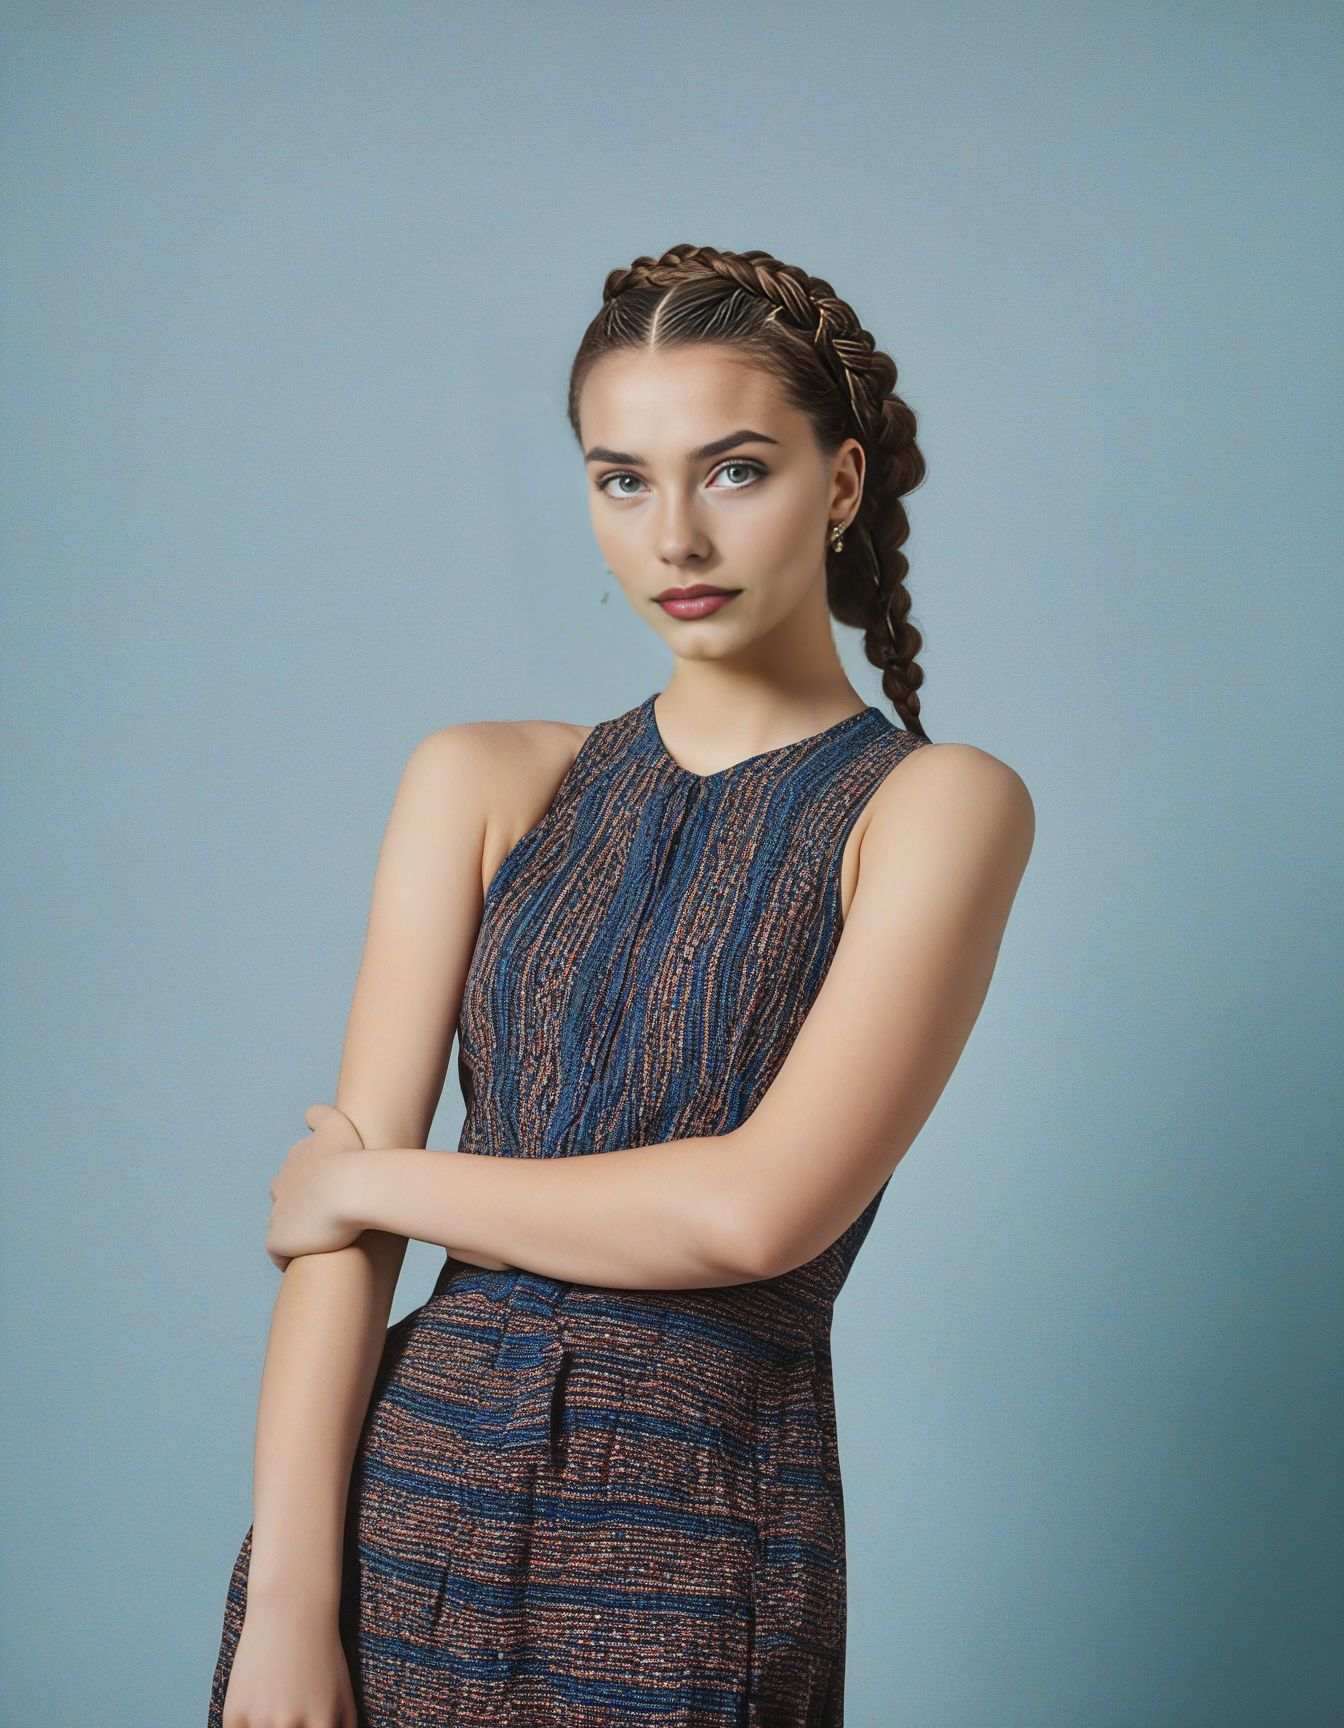

In [15]:
# displaying swapping result
from google.colab.patches import cv2_imshow
if swap_results is not None:
  cv2.imwrite("swappedImages.png", swap_results)
  cv2_imshow(swap_results)
else:
  print("Face Swap Failed.")

In [16]:
pip install git+https://github.com/huggingface/diffusers

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-phif9o3e
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-phif9o3e
  Resolved https://github.com/huggingface/diffusers to commit 61d96c3ae756e114d2c88089d6e5c11b18501fe8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.31.0.dev0-py3-none-any.whl size=2688791 sha256=e93b4be34d98ceeef63c2c8ed930ebbfc3b713b75bf8b54a2cd664fdc0f6974a
  Stored in directory: /tmp/pip-ephem-wheel-cache-x1bmkgmi/wheels/f7/7d/99/d361489e5762e3464b3811bc629e94cf5bf5ef44dd5c3c4d52
Successfully built diffusers


## Diffusion-Based Approach

In [17]:
from diffusers import StableDiffusionPipeline,StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [18]:
model = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True).to("cuda")
refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


model_index.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/4.52G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
from PIL import Image
source_img = Image.open("/content/img_folder/image_page1_1.jpeg")
target_img = Image.open("/content/img_folder/image_page1_3.jpeg")

In [20]:
# Convert to torch tensors and normalize to [0, 1]
source_img = torch.tensor(np.array(source_img), dtype=torch.float32).cuda() / 255.0
target_img = torch.tensor(np.array(target_img), dtype=torch.float32).cuda() / 255.0


In [21]:
torch.cuda.empty_cache()

In [22]:
source_img_cpu = source_img.cpu()
target_img_cpu = target_img.cpu()
with torch.no_grad():
    source_latents = model.vae.encode(torch.tensor(np.array(source_img_cpu), dtype=torch.float16).permute(2, 0, 1).unsqueeze(0).cuda() * 2 - 1).latent_dist.sample()
    target_latents = model.vae.encode(torch.tensor(np.array(target_img_cpu), dtype=torch.float16).permute(2, 0, 1).unsqueeze(0).cuda() * 2 - 1).latent_dist.sample()


In [23]:
# Check the shapes of the latent representations
print("Source latents shape:", source_latents.shape)
print("Target latents shape:", target_latents.shape)

Source latents shape: torch.Size([1, 4, 216, 168])
Target latents shape: torch.Size([1, 4, 128, 128])


In [24]:
import torch.nn.functional as F

# Resize the source_latents to match the target_latents size
source_latents_resized = F.interpolate(source_latents, size=target_latents.shape[2:], mode='bilinear', align_corners=False)

# Now blend the resized source_latents with the original target_latents
combined_latents = 0.5 * source_latents_resized + 0.5 * target_latents

print(f"Combined latents shape: {combined_latents.shape}")


Combined latents shape: torch.Size([1, 4, 128, 128])


In [25]:
generated_images = []
for latent in torch.split(combined_latents, split_size_or_sections=1, dim=0):
    with torch.no_grad():
        img = model.vae.decode(latent)
        generated_images.append(img.sample)
generated_img = torch.cat(generated_images)


In [26]:
generated_img = (generated_img / 2 + 0.5).clamp(0, 1)
generated_img = generated_img.detach().cpu().numpy()
# squeeze the tensor to remove the batch dimension
generated_img = generated_img.squeeze(0)
generated_img = generated_img.transpose(1, 2, 0)

In [28]:
output_img = Image.fromarray((generated_img * 255).astype(np.uint8))
output_img.save("/content/img_folder/swapped_face_sd.jpeg")
output_img.show()

<ipython-input-28-f79d272bd2d7>:1: RuntimeWarning: invalid value encountered in cast
  output_img = Image.fromarray((generated_img * 255).astype(np.uint8))
